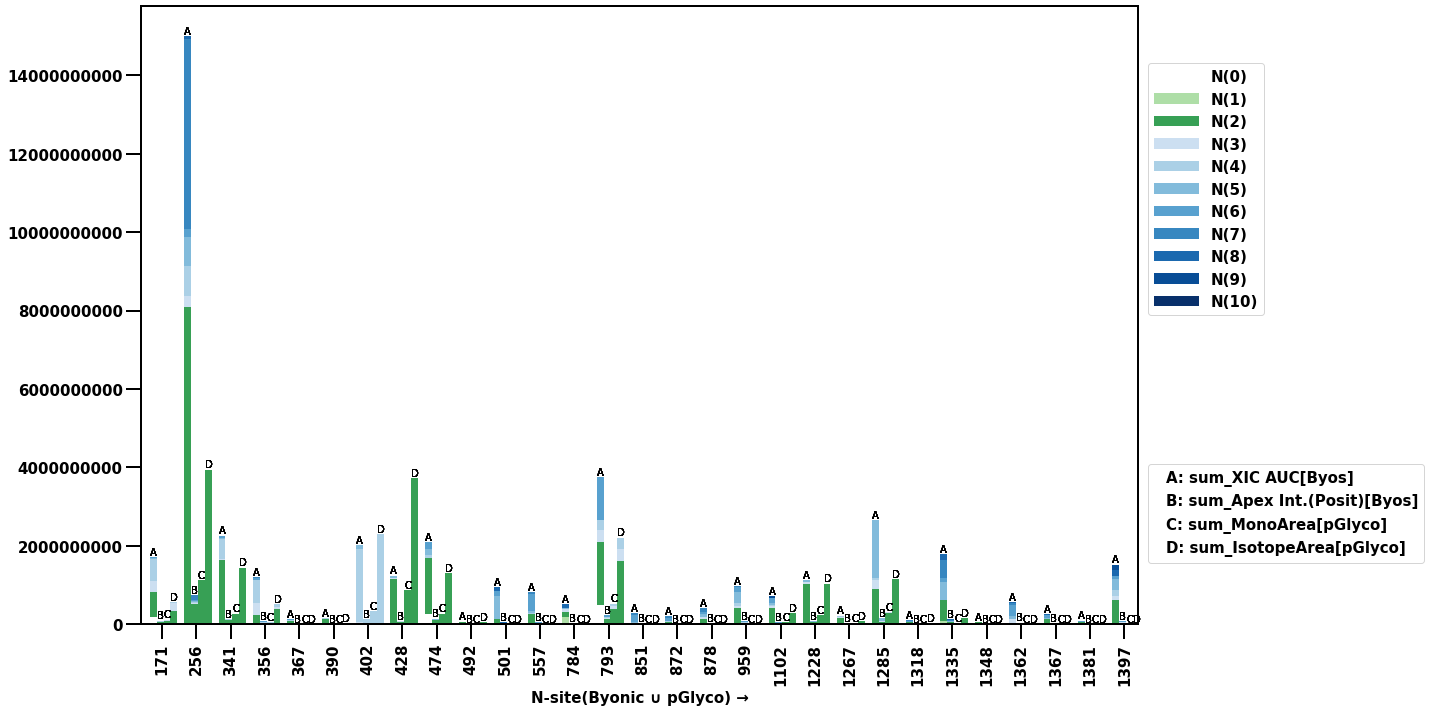

In [66]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import ticker
from IPython.display import display, HTML
import re # finding specific patterns in str
import textwrap # split text into equal parts
import collections # return repeated items in list
from collections import OrderedDict
import time
from datetime import datetime # attach current date to export filename
import sys
import ast # convert str back to tuple/list/int, etc
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_clustered_stacked(dfall, nsum, labels=None, title='', tickW=2, tickL=15, spineW=2, xlabelsize=15, ticklabelsize=15, xlabel_rotation=90, xlabelpad=5, legend_fontsize=15, legend_handleL=3, hatch_lineW=1, bar_labelpad=0, bar_labelfontsize=7):
    # Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot
    # labels is a list of the names of the dataframe, used for the legend
    # title is a string for the title of the plot
    # H is the hatch used for identification of the different dataframe
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    
    # sample the colormaps
    g = plt.cm.Greens(np.linspace(0, 1, 4))[1:3]
    b = plt.cm.Blues(np.linspace(0, 1, 10))[2:10]
    white = plt.cm.binary(np.linspace(0, 1, 256))[0]
    
    # combine them and build a new colormap
    colors = np.vstack((white, g, b))
    axe = plt.subplot(111)
    
    # make tick & spine thick.
    axes = plt.gca()
    axes.xaxis.set_tick_params(width=tickW, length=tickL)
    axes.yaxis.set_tick_params(width=tickW, length=tickL)
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(spineW)
        
    # start plotting
    bar_label = ['A', 'B', 'C', 'D']
    bar_label_cnt = 0
#     col_cnt = 0
    for df in dfall : # for each data frame
        axe = df.plot(kind='bar', stacked=True, ax=axe, legend=False, grid=False, figsize =(20, 10), color = colors)  # make bar plots
    
    # get the y aixs range
    ymin, ymax = axes.get_ylim()
    # get the handles we want to modify in each site, h: 44 barcontainers, l: 4 full N(x) cols
    h,l = axe.get_legend_handles_labels() 
    # print('h:%s\n'%h) 44 <BarContainer object of 29 artists> 
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df -> 0, 11, 22, 33
        for j, pa in enumerate(h[i:i+n_col]): # each pa.patches contains 29 <matplotlib.patches.Rectangle object>
            # print('pa.patches:%s\n'%pa.patches)
            rect_cnt = 0
            for rect in pa.patches: # each rect here is one single N(X) small rect of one single xicauc(int...etc) big rect. Note this loops thru the small rects spanning dif n-sites (29 small rects in one run)
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))    
                rect.set_width(1 / float(n_df + 1))
#                 print('col_cnt:%s\n'%col_cnt)
#                 if col_cnt in [i for i in range(n_col-1, len(h), n_col)]: # 10*29, 21*29, 32*29, 43*29 -> the last rects in each bar_label gp
#                     print('bar_label_cnt:%s\n'%bar_label_cnt)
#                     print('rect.get_y()+rect.get_height()+bar_labelpad:%s\n'%(rect.get_y()+rect.get_height()+bar_labelpad))
#                     axe.text(rect.get_x(), rect.get_y()+rect.get_height()+bar_labelpad, bar_label[bar_label_cnt], ha='left', va='bottom') # rect.get_y() <the base of rect> +rect.get_height() <the height of rect>
#             col_cnt += 1
                axe.text(rect.get_x(), nsum[bar_label_cnt][rect_cnt] + bar_labelpad, bar_label[bar_label_cnt], ha='left', va='bottom')
                rect_cnt += 1
        bar_label_cnt += 1
    
    axe.tick_params(axis='both', labelsize=ticklabelsize)
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = xlabel_rotation, fontweight="bold") 
    axe.set_xlabel(df.index.name, fontweight="bold", fontsize = xlabelsize, labelpad = xlabelpad)
    axe.ticklabel_format(axis='y', style='plain')
    for label in axe.get_yticklabels():
        label.set_fontweight('bold')
    axe.set_title(title)
    
    # legend properties
    params = {'legend.fontsize': legend_fontsize, 'legend.handlelength': legend_handleL, 'hatch.linewidth': hatch_lineW}
    legend_properties = {'weight':'bold'}
    plt.rcParams.update(params)
    
    # Add invisible data to add another legend 
    l1 = axe.legend(h[:n_col], l[:n_col], prop=legend_properties, loc=[1.01, 0.5])
    
    legend_elements = [] # for df legend (xicauc, int.. are from dif. df) 
    if labels is not None:      
        for i in range(n_df):
            label = '%s: %s'%(bar_label[i], labels[i])
            each_bullet = Patch(label = label)
            legend_elements.append(each_bullet)
        plt.legend(handles=legend_elements, handlelength = 0, prop=legend_properties, loc=[1.01, 0.1])
    axe.add_artist(l1)
    
    return axe

# bp_union NORM
bp_union = pd.read_excel('bp_union.xlsx', header = 0)
# fix the str '10' sorted before '2' problem
nx = list(set(bp_union['N(x) ↓'].tolist()))
nx = [int(re.findall(r'[0-9]+', i)[0]) if type(i) == str else i for i in nx]
nx.sort(key=lambda v: (isinstance(v, str), v))
bp_union_new_nx = ['N(%s)'%(str(i)) if type(i) == int and i != -1 else i for i in nx]
bp_union = bp_union.fillna('N/A')
fixed_colname = [i.replace('_x000D_', '\r') if '_x000D_' in i else i for i in bp_union.columns]
bp_union.columns = fixed_colname
# split bp_union into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucNORM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'a_norm_XIC\r\nAUC[Byos]']]
intNORM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'b_norm_Apex Int.\r\n(Posit)[Byos]']] 
monoNORM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'c_norm_MonoArea[pGlyco]']]
isoNORM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'd_norm_IsotopeArea[pGlyco]']]
xicaucNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
intNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)

columnsTitles = bp_union_new_nx
xicaucNORM_df = xicaucNORM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='a_norm_XIC\r\nAUC[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=columnsTitles)
intNORM_df = intNORM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='b_norm_Apex Int.\r\n(Posit)[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=columnsTitles)
monoNORM_df = monoNORM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='c_norm_MonoArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=columnsTitles)
isoNORM_df = isoNORM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='d_norm_IsotopeArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=columnsTitles)

# myfig = plot_clustered_stacked([xicaucNORM_df, intNORM_df, monoNORM_df, isoNORM_df],[[1]*29, [1]*29, [1]*29, [1]*29],['norm_XIC AUC[Byos]', 'norm_Apex Int.(Posit)[Byos]', 'norm_MonoArea[pGlyco]', 'norm_IsotopeArea[pGlyco]']).figure
# myfig.tight_layout()
# myfig.savefig('bpUnionNORM_Figures.png')

# bp_union SUM
# split bp_union into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucSUM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'e_sum_XIC\r\nAUC[Byos]']]
intSUM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'f_sum_Apex Int.\r\n(Posit)[Byos]']] 
monoSUM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'g_sum_MonoArea[pGlyco]']]
isoSUM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'h_sum_IsotopeArea[pGlyco]']]
xicaucSUM_df.replace(to_replace = -1, value = np.nan , inplace = True)
intSUM_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoSUM_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoSUM_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucSUM_df = xicaucSUM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='e_sum_XIC\r\nAUC[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=columnsTitles)
intSUM_df = intSUM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='f_sum_Apex Int.\r\n(Posit)[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=columnsTitles)
monoSUM_df = monoSUM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='g_sum_MonoArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=columnsTitles)
isoSUM_df = isoSUM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='h_sum_IsotopeArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=columnsTitles)

xicaucSUM_df_nsum = [xicaucSUM_df.loc[i].sum() for i in xicaucSUM_df.index.tolist()] # for A bar label
intSUM_df_nsum = [intSUM_df.loc[i].sum() for i in intSUM_df.index.tolist()] # for B bar label
monoSUM_df_nsum = [monoSUM_df.loc[i].sum() for i in monoSUM_df.index.tolist()] # for C bar label
isoSUM_df_nsum = [isoSUM_df.loc[i].sum() for i in isoSUM_df.index.tolist()] # for D bar label
nsum = [xicaucSUM_df_nsum, intSUM_df_nsum, monoSUM_df_nsum, isoSUM_df_nsum]
intSUM_df
myfig = plot_clustered_stacked([xicaucSUM_df, intSUM_df, monoSUM_df, isoSUM_df],nsum,['sum_XIC AUC[Byos]', 'sum_Apex Int.(Posit)[Byos]', 'sum_MonoArea[pGlyco]', 'sum_IsotopeArea[pGlyco]']).figure
myfig.tight_layout()
myfig.savefig('bpUnionSUM_Figures.png')


In [93]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
# c = [['#ccffcc', '#008000']] + plt.cm.Blues(np.linspace(0, 1, 9))
# c = plt.cm.Blues(np.linspace(0, 1, 9))
c

# sample the colormaps
# colors in total
g = plt.cm.Greens(np.linspace(0, 1, 2))
b = plt.cm.Blues(np.linspace(0, 1, 9))
# combine them and build a new colormap
colors = np.vstack((g, b))
# mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
print(colors)
# a = [[1, 2]]
# b = [[3, 4], [5, 6]]
# a+b

[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.         0.26666667 0.10588235 1.        ]
 [0.96862745 0.98431373 1.         1.        ]
 [0.87021915 0.92132257 0.96850442 1.        ]
 [0.77524029 0.85830065 0.9368243  1.        ]
 [0.6172549  0.79086505 0.88184544 1.        ]
 [0.41708574 0.68063053 0.83823145 1.        ]
 [0.25628604 0.57001153 0.7751634  1.        ]
 [0.12710496 0.44018454 0.70749712 1.        ]
 [0.03137255 0.31409458 0.60648981 1.        ]
 [0.03137255 0.18823529 0.41960784 1.        ]]
